C:\Users\manas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 262k/262k [00:01<00:00, 237kB/s]

Extracting files...


Path to dataset files: C:\Users\manas\.cache\kagglehub\datasets\shantanudhakadd\bank-customer-churn-prediction\versions\1
Files in dataset directory:
  - Churn_Modelling.csv
Loading dataset from: C:\Users\manas\.cache\kagglehub\datasets\shantanudhakadd\bank-customer-churn-prediction\versions\1\Churn_Modelling.csv
Dataset shape: (10000, 14)
Columns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

DATASET EXPLORATION

First 5 rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Fe

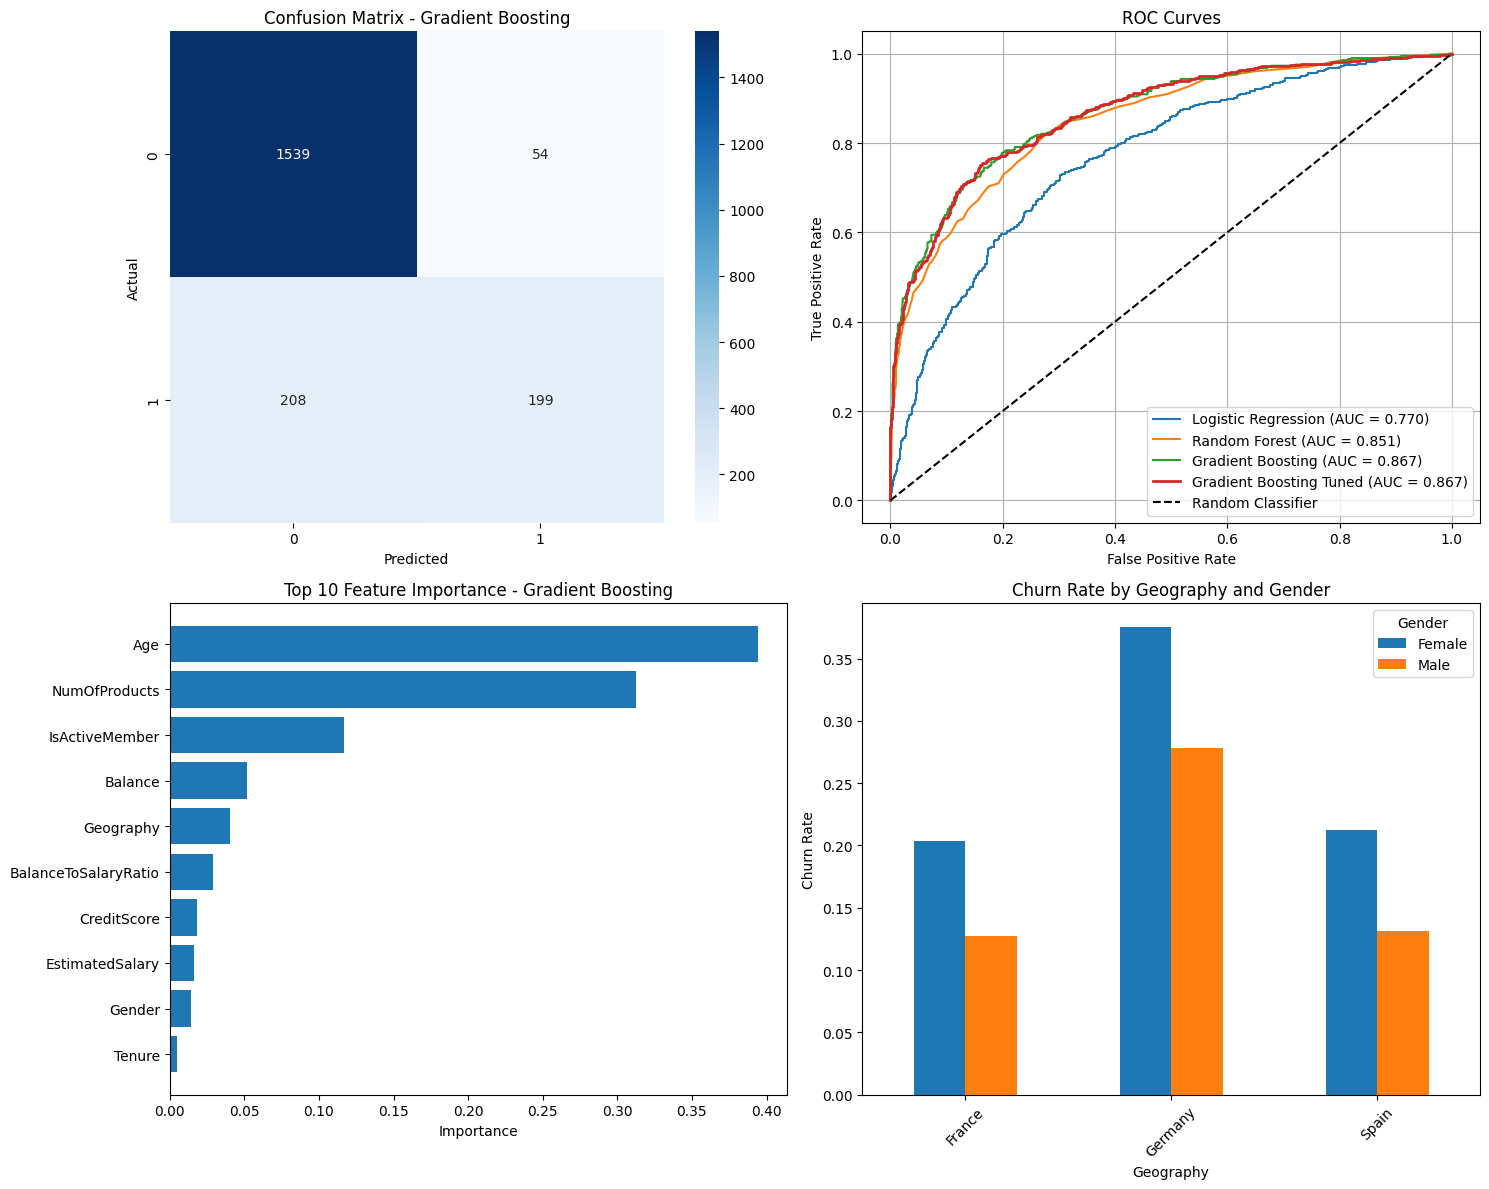


BUSINESS INSIGHTS AND RECOMMENDATIONS

Overall Churn Rate: 20.37%

Key Drivers of Customer Churn:
  - Age: 0.3943
  - NumOfProducts: 0.3127
  - IsActiveMember: 0.1171
  - Balance: 0.0521
  - Geography: 0.0406

Recommended Actions:
1. Identify high-risk customer segments based on model predictions
2. Implement targeted retention campaigns for at-risk customers
3. Monitor key drivers identified by the model
4. Develop proactive engagement strategies
5. Regularly retrain model with new data

Best model saved as 'customer_churn_model.pkl'

Model is ready for deployment!


In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Download latest version
print("Downloading Bank Customer Churn Prediction dataset...")
path = kagglehub.dataset_download("shantanudhakadd/bank-customer-churn-prediction")
print("Path to dataset files:", path)

# Load the dataset
def load_dataset(dataset_path):
    """Load the bank customer churn dataset"""
    import os
    
    # List files in the dataset directory
    print("Files in dataset directory:")
    for file in os.listdir(dataset_path):
        print(f"  - {file}")
    
    # Look for CSV files
    csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
    
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the dataset directory")
    
    # Load the first CSV file (usually the main dataset)
    dataset_file = os.path.join(dataset_path, csv_files[0])
    print(f"Loading dataset from: {dataset_file}")
    
    df = pd.read_csv(dataset_file)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    return df

# Load and explore the dataset
df = load_dataset(path)

# Display basic information
print("\n" + "="*50)
print("DATASET EXPLORATION")
print("="*50)

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())

print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget variable distribution:")
if 'Exited' in df.columns:
    target_col = 'Exited'
elif 'Churn' in df.columns:
    target_col = 'Churn'
else:
    # Try to find the target column
    for col in df.columns:
        if 'exit' in col.lower() or 'churn' in col.lower() or 'attrition' in col.lower():
            target_col = col
            break
    else:
        target_col = df.columns[-1]  # Assume last column is target

print(f"Target column: {target_col}")
print(df[target_col].value_counts())
print(f"Churn rate: {df[target_col].mean():.2%}")

# Data Preprocessing
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

def preprocess_data(df, target_col):
    """Preprocess the data for churn prediction"""
    
    # Create a copy of the dataframe
    data = df.copy()
    
    # Handle missing values
    print("Handling missing values...")
    missing_cols = data.columns[data.isnull().any()].tolist()
    if missing_cols:
        print(f"Columns with missing values: {missing_cols}")
        # Numerical columns - impute with median
        num_cols = data.select_dtypes(include=[np.number]).columns
        num_imputer = SimpleImputer(strategy='median')
        data[num_cols] = num_imputer.fit_transform(data[num_cols])
        
        # Categorical columns - impute with mode
        cat_cols = data.select_dtypes(include=['object']).columns
        cat_imputer = SimpleImputer(strategy='most_frequent')
        data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])
    
    # Encode categorical variables
    print("Encoding categorical variables...")
    label_encoders = {}
    categorical_columns = data.select_dtypes(include=['object']).columns
    
    for col in categorical_columns:
        if col != target_col:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le
            print(f"  Encoded {col}: {len(le.classes_)} categories")
    
    # Feature engineering (if needed)
    print("Performing feature engineering...")
    
    # Check for common banking features and create new ones if possible
    if 'Balance' in data.columns and 'EstimatedSalary' in data.columns:
        data['BalanceToSalaryRatio'] = data['Balance'] / (data['EstimatedSalary'] + 1)
        print("  Created BalanceToSalaryRatio")
    
    if 'CreditScore' in data.columns:
        data['CreditScoreGroup'] = pd.cut(data['CreditScore'], 
                                        bins=[0, 580, 670, 740, 800, 850],
                                        labels=[0, 1, 2, 3, 4])
        print("  Created CreditScoreGroup")
    
    # Remove unnecessary columns
    columns_to_drop = ['CustomerId', 'Surname', 'RowNumber']  # Common ID columns
    columns_to_drop = [col for col in columns_to_drop if col in data.columns]
    if columns_to_drop:
        data = data.drop(columns=columns_to_drop)
        print(f"  Dropped columns: {columns_to_drop}")
    
    return data, label_encoders

# Preprocess the data
df_processed, label_encoders = preprocess_data(df, target_col)

print(f"\nProcessed dataset shape: {df_processed.shape}")
print(f"Processed columns: {df_processed.columns.tolist()}")

# Prepare features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")

# Scale numerical features
print("\nScaling numerical features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for better visualization
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Feature scaling completed!")

# Model Training and Evaluation
print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate a model and return metrics"""
    print(f"\n{model_name}")
    print("-" * len(model_name))
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = model.score(X_test, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance (if available)
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Feature Importances:")
        print(feature_importance.head(10))
    
    return {
        'model': model,
        'accuracy': accuracy,
        'auc_score': auc_score,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'feature_importance': feature_importance if hasattr(model, 'feature_importances_') else None
    }

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)

# Model Comparison
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'AUC Score': [results[model]['auc_score'] for model in results]
}).sort_values('AUC Score', ascending=False)

print(comparison_df)

# Find the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")

# Hyperparameter Tuning for the best model
print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
else:  # Gradient Boosting
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }

print(f"Performing GridSearchCV for {best_model_name}...")
grid_search = GridSearchCV(
    best_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Final evaluation with tuned model
best_tuned_model = grid_search.best_estimator_
y_pred_tuned = best_tuned_model.predict(X_test_scaled)
y_pred_proba_tuned = best_tuned_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nTuned {best_model_name} Performance:")
print(f"Accuracy: {best_tuned_model.score(X_test_scaled, y_test):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")

# Visualization
print("\n" + "="*50)
print("VISUALIZATION")
print("="*50)

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'Confusion Matrix - {best_model_name}')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# 2. ROC Curves for all models
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    auc_score = result['auc_score']
    axes[0, 1].plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

# Add tuned model ROC curve
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_proba_tuned)
auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
axes[0, 1].plot(fpr_tuned, tpr_tuned, label=f'{best_model_name} Tuned (AUC = {auc_tuned:.3f})', linewidth=2)

axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curves')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 3. Feature Importance (if available)
if best_model_name != 'Logistic Regression':
    feature_importance = results[best_model_name]['feature_importance']
    top_features = feature_importance.head(10)
    axes[1, 0].barh(range(len(top_features)), top_features['importance'])
    axes[1, 0].set_yticks(range(len(top_features)))
    axes[1, 0].set_yticklabels(top_features['feature'])
    axes[1, 0].set_xlabel('Importance')
    axes[1, 0].set_title(f'Top 10 Feature Importance - {best_model_name}')
    axes[1, 0].invert_yaxis()

# 4. Churn Rate by Important Features (example)
if 'Geography' in df.columns and 'Gender' in df.columns:
    churn_by_geo_gender = df.groupby(['Geography', 'Gender'])[target_col].mean().unstack()
    churn_by_geo_gender.plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Churn Rate by Geography and Gender')
    axes[1, 1].set_ylabel('Churn Rate')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Business Insights and Recommendations
print("\n" + "="*50)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*50)

print(f"\nOverall Churn Rate: {df[target_col].mean():.2%}")

# Key drivers analysis
if best_model_name != 'Logistic Regression':
    print("\nKey Drivers of Customer Churn:")
    feature_importance = results[best_model_name]['feature_importance']
    for _, row in feature_importance.head(5).iterrows():
        print(f"  - {row['feature']}: {row['importance']:.4f}")

# Example business recommendations
print("\nRecommended Actions:")
print("1. Identify high-risk customer segments based on model predictions")
print("2. Implement targeted retention campaigns for at-risk customers")
print("3. Monitor key drivers identified by the model")
print("4. Develop proactive engagement strategies")
print("5. Regularly retrain model with new data")

# Save the best model
import joblib

model_artifacts = {
    'model': best_tuned_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_names': X.columns.tolist(),
    'target_column': target_col
}

joblib.dump(model_artifacts, 'customer_churn_model.pkl')
print(f"\nBest model saved as 'customer_churn_model.pkl'")

# Prediction function for new customers
def predict_churn(new_customer_data, model_artifacts):
    """Predict churn probability for new customers"""
    model = model_artifacts['model']
    scaler = model_artifacts['scaler']
    label_encoders = model_artifacts['label_encoders']
    feature_names = model_artifacts['feature_names']
    
    # Preprocess new customer data
    new_data = new_customer_data.copy()
    
    # Encode categorical variables
    for col, encoder in label_encoders.items():
        if col in new_data.columns:
            new_data[col] = encoder.transform(new_data[col])
    
    # Ensure all features are present
    for col in feature_names:
        if col not in new_data.columns:
            new_data[col] = 0  # or appropriate default value
    
    # Reorder columns to match training data
    new_data = new_data[feature_names]
    
    # Scale features
    new_data_scaled = scaler.transform(new_data)
    
    # Predict
    churn_probability = model.predict_proba(new_data_scaled)[:, 1]
    churn_prediction = model.predict(new_data_scaled)
    
    return churn_prediction, churn_probability

print("\nModel is ready for deployment!")